# INFO 3350/6350

## Lecture 08: Feature selection

## To do

* Problem set 2 due Thursday, 9/28, at 11:59pm
* Reading for section
    * Read articles by Underwood, by Yauney, and by Piper
* Problem set 3 will be released one week later than originally scheduled.
    * Problem set due dates will be adjusted accordingly

## Feature selection

We've spoken before about **overfitting**. A model that is overfit has learned features of the training data that are unlikely to generalize to new, unseen data. As a rule of thumb, a model is very likely to be overfit if it uses on the order of as many features as the training data contains examples. The signature of an overfit model is good performance when evaluated against the training data, but poor performance when evaluated against held-out test data. 

Dimension reduction is one approach to addressing overfitting. Another is **feature selection**. When we select features to retain in our model, we're looking for ones that seem likely to provide useful information about the relationship between our objects and the class labels we seek to assign. Two useful approaches to feature selection are **ANOVA f-statistics** and **mutual information**.

### *F*-statistic and ANOVA analysis

We won't say much more about ANOVA analysis; you should have seen it in your stats class. It's conceptually similar to a *t*-test, in that it compares the difference in the means of two groups relative to the variance within each group. A large *F*-statistic means that two samples are significantly different. In our case, we're comparing the distribution of values within each feature to the distribution of true labels in the training data. Intuitively, a feature may be a good predictor of the class label if its distribution is similar to the distribution of the label, hence if the F-statistic between them is small. (But note that scikit-learn's `f_classif` method returns the inverse of the *F*-statistic, such that a large result indicates a likely *useful* feature.)

The problem with the *F*-statistic is that it only captures linear, normally distributed relationships. The advantages are (1) that this assumption is often valid and (2), it's super easy to calculate, so is fast when run on large datasets.

### Mutual information

**Mutual information** (MI) is abstractly similar to correlation or covariance -- it's a measure of how much two variables change together. But MI doesn't assume a linear relationship between the variables and it's suitable for categorical data, so is often preferred for our purposes.

If you want the math, in the case of categorical data (like we're using here with word counts and class labels), mutual information is calculated as:

$$MI(U,V)=\sum_{i=1}^{|U|} \sum_{j=1}^{|V|}\frac{|U_i\cap V_j|}{N}\log\frac{N|U_i \cap V_j|}{|U_i||V_j|}$$

Where $\cap$ indicates the **insection** of two sets. $N$ is the total number of observations in each vector. $i$ and $j$ represent the possible values in each vector. And $|U_i|$ is the count of instances of value $i$ in vector $U$.

If we have two vectors, $U = [1,0]$ and $V = [1,0]$, we know that our MI score should be high, since $U$ is identical to $V$. For an *n*-class problem, the maximum unnormalized MI is log(*n*). In our example, $N$ = 2 (two observations per vector) and $i$ and $j$ are both drawn from `[1,0]` (or `[0,1]`, it doesn't matter). Hence:

$$MI(U,V) = \frac{1}{2}\log\frac{2(1)}{1(1)} + 0 + 0 + \frac{1}{2}\log\frac{2(1)}{1(1)} = 0.693147$$

The zeros correspond in this example to misaligned labels, of which there are none, hence $|U_i\cap V_j| = 0$ for all $i\neq j$ (again, in this specific example of perfect label alignment, not in all cases).

Or consider the slightly more interesting case where $U = [1,1,2]$ and $V = [1,2,2]$. In this case, we calculate:

$$MI(U,V) = \frac{1}{3}\log\frac{3(1)}{2(1)} + \frac{1}{3}\log\frac{3(1)}{2(2)} + 0 + \frac{1}{3}\log\frac{3(1)}{1(2)} = 0.174416$$

Mutual information is often (but not always) reported on a *normalized* basis, in which the raw MI value is divided by log($N$) (or, technically, by the mean entropy of the two variables, but it amounts to the same thing when there are the same number of classes in each variable), the maximum possible MI value for the case. The normalized MI for the first example is 0.693147/log(2) = 1.0. In the second example, normalized MI = 0.174416/log(3) = 0.15876.

See the [sklearn documentation for `mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) for more information.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import StandardScaler

### Demo on trivial data

In [2]:
# f-stat
X = np.array([[1,1,1,1,0,0], [1,0,1,0,1,0]]).T
y = np.array([1,1,1,0,0,0])
f_stat, p_vals = f_classif(X,y)
print("f statistic:", f_stat)
print("p values:", p_vals)

f statistic: [4.  0.5]
p values: [0.11611652 0.51851852]


In [3]:
# automated selection
SelectKBest(k=1, score_func=f_classif).fit_transform(X,y) # note score_func

array([[1],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [4]:
# mutual info
mutual_info_classif(X,y)

array([1.10277778, 0.        ])

## A small corpus

About 125,000 news articles, distributed evenly across four categories (world, business, sports, and science/technology), each trimmed to contain **just the first sentence or two of the original article**. [Data source](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv), plus minor massaging into current format.

Our task will be to predict the category of any news article using a Bayesian classifier, and to examine the impact of feature selection on model performance.

### Read and clean news data

In [5]:
# read data from disk and examine
news = pd.read_csv(os.path.join('..', 'data', 'news', 'news_text.csv.gz'))
news.head(20)

,label,body
0,Sci_Tech,Mobile phone giant Nokia has unveiled its firs...
1,Sports,"ADELAIDE, Nov 30: Australia crushed New Zealan..."
2,Sports,"Flinching in the trenches, holding around quar..."
3,Sports,Miami Dolphins owner Wayne Huizenga and presid...
4,Sci_Tech,InfoWorld - PeopleSoft's Board of Directors vo...
5,Sci_Tech,"AP - Edward Bitet fought in World War II, buil..."
6,Business,"LARRY Ellison, the chief executive of software..."
7,Sci_Tech,AP - Indonesian police on Tuesday summoned the...
8,World,AP - Police defused a time-bomb in a town near...
9,World,A full season has passed since the UN Security...


I bet those datelines will be a problem. Let's get rid of them.

In [6]:
# a function to get rid of datelines at the start of articles
#  matches one or more hyphens or colons in first 40 chars,
#  drops everything before that match (plus the match itself)
pattern = '[-:]+ '
matcher = re.compile(pattern) # compiled regexs are faster

def remove_dateline(text, matcher=matcher):
    '''
    Remove source names and datelines from a text string
    If there is a hyphen or colon in the first 40 characters, 
      drops everything before the hyphen(s)/colon(s)
    If no hyphen/colon, do nothing
    Return processed string
    '''
    result = matcher.search(text, endpos=40)
    if result:
        return text[result.end():]
    else:
        return text

In [7]:
# clean article text
news['body'] = news['body'].apply(remove_dateline)

In [8]:
# confirm articles are cleaned
news.head(20)

,label,body
0,Sci_Tech,Mobile phone giant Nokia has unveiled its firs...
1,Sports,Australia crushed New Zealand by 213 runs on t...
2,Sports,"Flinching in the trenches, holding around quar..."
3,Sports,Miami Dolphins owner Wayne Huizenga and presid...
4,Sci_Tech,PeopleSoft's Board of Directors voted Wednesda...
5,Sci_Tech,"Edward Bitet fought in World War II, built aff..."
6,Business,"LARRY Ellison, the chief executive of software..."
7,Sci_Tech,Indonesian police on Tuesday summoned the Amer...
8,World,Police defused a time-bomb in a town near Prim...
9,World,A full season has passed since the UN Security...


### Compute token counts

In [9]:
# set up a vectorizer object
count_vectorizer = CountVectorizer(
    strip_accents='unicode', # collapse accents to base character
    stop_words=None, # do not remove stop words
    binary=False, # do not binarize features
    #max_features=1000,
    min_df=0.001 # limit features to those that occur in at least 0.1% of articles
)

# perform vectorization
X = count_vectorizer.fit_transform(news['body'])

# vectorized shape
X.shape

(127600, 3486)

In [10]:
# what do the columns measure?
count_vectorizer.get_feature_names_out()[200:210]

array(['amd', 'america', 'american', 'americans', 'amid', 'among',
       'amount', 'amp', 'an', 'anaheim'], dtype=object)

In [11]:
# total word count in our corpus?
X.sum()

3216050

This corpus isn't very big. Or, well, the documents are pretty short, on average: 3.2M words / 127k documents = about 25 words per document. This fact will make classification a little harder than it would be if we had full documents.

### Classify sports (vs everything else)

We'll try **Bernouli naïve Bayes**, **Multinomial naïve Bayes**, and **Gaussian naïve Bayes** classifiers. The difference is that the Bernouli version first transforms our input features into ones and zeros, thereby coding for the presence or absence of each word in each document (but not accounting for how many times the word occurs in the document). Multinomial NB does not binarize inputs, so accounts for the number of occurrences. But Multinomial NB *does* expect nonnegative integers as input. Gaussian NB works with continuous inputs.

There's no principled reason to prefer Bernouli, multinomial, or Gaussian NB. Use whichever one produces better results on your data (and is suitable for the type of input data you're using). Bernouli can be useful in the case where most documents use any word only a few times at most, rare documents use some words very many times, but you don't consider the rare, high-usage documents to be fundamentally unlike the other documents that use the same words just a few times.

**Remember:** when we call `.fit()` (as we do explicitly here, or under the hood of `cross_val_score`, for example), what we're learning are the empirical probabilities of each word in each class.

In [12]:
news.label.unique()

array(['Sci_Tech', 'Sports', 'Business', 'World'], dtype=object)

In [13]:
news.label.value_counts()

label
Sci_Tech    31900
Sports      31900
Business    31900
World       31900
Name: count, dtype: int64

In [14]:
# make boolean array of sports/other labels
y = news['label'] == 'Sports'

In [15]:
# split into train and test sets
# --> limit to 1000 articles for demo purposes <--
X_train, X_test, y_train, y_test = train_test_split(X[:1000], y[:1000])

In [16]:
# score BernouliNB classifier on train and test data
clf = BernoulliNB().fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
print("Performance on TRAINING data")
print(classification_report(y_train_pred, y_train))

Performance on TRAINING data
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       578
        True       0.88      0.99      0.93       172

    accuracy                           0.97       750
   macro avg       0.94      0.97      0.95       750
weighted avg       0.97      0.97      0.97       750



In [17]:
y_test_pred = clf.predict(X_test)
print("Performance on TEST data")
print(classification_report(y_test_pred, y_test))

Performance on TEST data
              precision    recall  f1-score   support

       False       0.99      0.90      0.94       201
        True       0.70      0.96      0.81        49

    accuracy                           0.91       250
   macro avg       0.85      0.93      0.88       250
weighted avg       0.93      0.91      0.92       250



There is evidence of overfitting in this case, because we perform significantly better when we make preditions on the training data than when we do the same on held-out test data

How about in the multinomial case?

In [18]:
# score Multinomial classifier on train and test data
clf = MultinomialNB().fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
print("Performance on TRAINING data")
print(classification_report(y_train_pred, y_train))

Performance on TRAINING data
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       556
        True       0.98      0.98      0.98       194

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [19]:
y_test_pred = clf.predict(X_test)
print("Performance on TEST data")
print(classification_report(y_test_pred, y_test))

Performance on TEST data
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       177
        True       0.94      0.86      0.90        73

    accuracy                           0.94       250
   macro avg       0.94      0.92      0.93       250
weighted avg       0.94      0.94      0.94       250



Multinomial NB performs just a tiny bit better in this case, but not enough to matter, really. And we're obviously still overfitting.

Aside: One reason to like NB classifiers is that they're really fast. Sklearn's NB classifiers are over 100 times faster than logistic regression on the same task (and they produce comparable accuracy). This equivalent accuracy won't always be true, of course, but the speedup can be a big plus with large datasets.

Bernouli NB is slower than multinomial NB due to binarization overhead. But the difference is trivial here.

### Select the most informative features

Let's see how well we can do with lower-dimension inputs. We'll do this in two ways:

1. Rank the input features (token counts) according to the degree to which their presence/absence matches the presence/absence of the `sports` class label. High mutual information between tokens and class labels suggests that a token will be a useful feature for our classifier. We'll also evaluate the *F*-statistic as a criterion and try out permutation importance, too.

2. We'll also try dimension reduction via Truncated SVD, as we studied in previous lectures.

#### Mutual information

In [20]:
# calculate mutual info scores btw each feature and the target label
%time mi = mutual_info_classif(X_train, y_train)

CPU times: user 4.28 s, sys: 36.6 ms, total: 4.32 s
Wall time: 4.37 s


Not fast!

In [21]:
mi.shape

(3486,)

In [22]:
mi

array([1.85941293e-03, 4.21314616e-03, 1.08434263e-03, ...,
       1.47736048e-03, 7.59141967e-07, 3.96985610e-04])

In [23]:
# get indices of mi array, sorted from highest to lowest mutual info
mi_indices = np.flip(mi.argsort()) # np.flip reverses order; want high -> low
mi_indices

array([ 810, 3131, 1636, ...,  758,  757, 1422])

**Discuss**: What do you expect to be some of the most informative features (words) for the **sports** catengory? That is, what words occurs often in sports stories, but not very often in other kinds of news articles?

In [24]:
# the single most informative sports feature
count_vectorizer.get_feature_names_out()[810]

'cup'

In [25]:
# sort the feature data and column labels
X_train_sorted = X_train[:, mi_indices]
X_test_sorted = X_test[:, mi_indices]
features_sorted = np.array(count_vectorizer.get_feature_names_out())[mi_indices]
features_sorted[:10]

array(['cup', 'the', 'its', 'game', 'company', 'season', 'sox', 'victory',
       'at', 'his'], dtype=object)

In [26]:
# performance with top 100 features
clf = MultinomialNB().fit(X_train_sorted[:,:100], y_train)
y_pred = clf.predict(X_test_sorted[:,:100])
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.92      0.97      0.94       174
        True       0.91      0.80      0.85        76

    accuracy                           0.92       250
   macro avg       0.91      0.88      0.90       250
weighted avg       0.92      0.92      0.91       250



Note that we've suffered just three points of weighted average F1 decrease despite throwing away all but 100 out of more than 3,500 original features.

Let's see how performance responds in input feature dimensionality in this case.

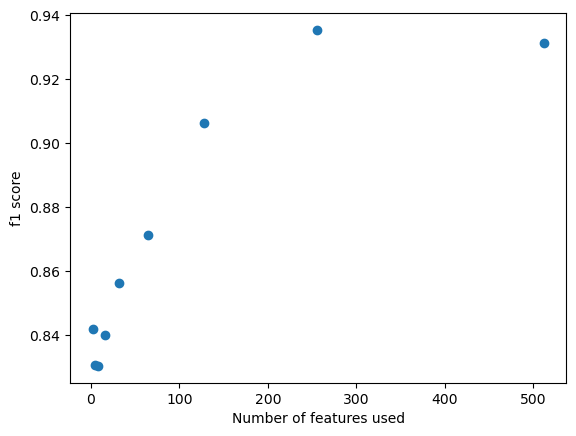

In [27]:
# how does performance respond to number of features used?
num_features = [2**i for i in range(1,10)]
f1s = []
for i in num_features:
    clf = MultinomialNB().fit(X_train_sorted[:,:i], y_train)
    y_pred = clf.predict(X_test_sorted[:,:i])
    f1s.append(f1_score(y_pred, y_test, average='weighted'))

plt.scatter(num_features, f1s)
plt.xlabel("Number of features used")
plt.ylabel("f1 score")
plt.show()

#### In practice

Split into train and test, fit a model, predict class labels, and examine classification errors. This is a typical workflow in production.

We can make things a little easier by using the `SelectKBest` method, which handles all of the sorting and indexing that we performed by hand above.

In [28]:
# using the n most-informative features

# fit selector
n_features = 100
selector = SelectKBest(k=n_features, score_func=mutual_info_classif).fit(X_train, y_train)

# select best features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# fit and predict
clf = MultinomialNB().fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)

# examine performance
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.92      0.97      0.94       174
        True       0.91      0.80      0.85        76

    accuracy                           0.92       250
   macro avg       0.91      0.88      0.90       250
weighted avg       0.92      0.92      0.91       250



In [29]:
# select erroneous predictions
errors = y_test != y_pred             # boolean array of gold/pred mismatches
errors = np.where(errors==True)       # index array of test set error locations
error_index = y_test.index[errors[0]] # map test-set error positions to original indices

news_errors = news.loc[error_index, ['label', 'body']] # select errors from original data

with pd.option_context('display.max_colwidth', 0): # display errors
    display(news_errors.sample(5))

,label,body
466,World,A computer firm is criticised by the Kennedy family for producing a game recreating the president's death.
537,Sports,It was another hard luck story for Martin ONeills demoralised Celtic in the Ukraine as an emphatic Francelino Matuzalem double and exquisite Brandao chip in the second half left their European dreams in tatters with Shakhtar Donetsk running out 3-0
717,Sci_Tech,"iraffes evolved long necks to browse in trees high above the competition. That is as plain as the explanation the wolf in granny clothing gave Little Red Riding Hood for his big teeth: quot;The better to eat you with, my dear."
456,World,"Inflexible demands from the Democratic Unionist party for verifiable photographic evidence of IRA arms decommissioning may scupper any deal to win a final agreement on power sharing, Sinn Fein leader Gerry Adams has warned."
357,World,"Argentina defeated the United States team of National Basketball Association stars 89-81 here Friday in the Olympic semi-finals, dethroning the three-time defending champions."


#### Truncated SVD

Compare performance using SVD in place of most-informative features.

In lecture, we talked about **standardizing** our input features before performing SVD, so that the variance isn't dominated simply by high-frequency words (in this case, words like "and" and "the" - we didn't perform stopword removal). Here, we're going to skip that step, so that we can preserve input sparsity (hence, computational and memory efficiency).

If we *were* going to standradize our features, we'd do something like:

```
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray()) # cast input to dense array
```
We would need to transform our input matrix to dense format with `.toarray()`, since `StandardScaler` refuses to break sparsity. And if we were going to do all that, we'd be performing PCA anyway, so we'd just use PCA in that case.

In [30]:
# reduce input dimensionality
reducer = TruncatedSVD(n_components=100)
X_train_reduced = reducer.fit_transform(X_train)
X_test_reduced = reducer.transform(X_test)
X_train_reduced.shape

(750, 100)

In [31]:
# examine new features for the first document
X_train_reduced[0]

array([ 2.31091066,  0.46807782, -0.05123493, -0.11804844, -1.44214166,
       -1.61755677, -0.16836875,  0.45318211, -0.20901811,  0.20750932,
       -0.18166563, -0.16878906, -0.37161433,  0.02205434,  0.16096509,
       -0.00771456, -0.28651371,  0.0951165 ,  0.20683053, -0.30117915,
        0.12964558, -0.28585854,  0.4328361 , -0.17722594,  0.18678913,
        0.10998431,  0.10973894,  0.07785721, -0.16235805, -0.18606315,
        0.19862304,  0.03998141,  0.42045065, -0.40884487, -0.16517306,
       -0.16891948, -0.05556175,  0.06227619, -0.29965067,  0.66018029,
        0.44071357, -0.16635564,  0.03439211,  0.25005065, -0.03554901,
        0.49123743,  0.03430947,  0.2027835 ,  0.36654219, -0.19774376,
       -0.02412514,  0.31231219, -0.07855019,  0.38262039,  0.1487356 ,
       -0.04198423,  0.06309975,  0.31976923, -0.04078521, -0.00840702,
        0.33987499, -0.29881305,  0.27568114,  0.31915805,  0.0308687 ,
        0.19223981,  0.1118394 ,  0.4562702 ,  0.18435949,  0.16

In [32]:
# could examine loadings
reducer.components_

array([[ 5.76746740e-03,  1.08706336e-02,  2.47264787e-03, ...,
         1.76649371e-03,  2.06471155e-03,  3.31543602e-04],
       [ 5.98247672e-03,  9.75716632e-03,  2.95632442e-03, ...,
        -6.93092875e-04,  5.14572838e-05,  4.44840034e-04],
       [ 1.09210094e-03, -1.08394720e-02, -1.84917615e-03, ...,
         5.05780107e-04, -1.54869316e-03,  3.11143566e-04],
       ...,
       [-5.95369138e-02, -6.38721428e-02,  7.26796949e-03, ...,
         2.65635969e-03,  1.97256291e-02,  1.82362616e-03],
       [ 4.63977149e-03,  1.29233581e-02,  1.30265353e-02, ...,
         1.76363862e-03,  4.46687452e-03,  2.74234232e-03],
       [ 1.52801972e-02,  5.73560159e-02,  1.16232726e-02, ...,
        -5.43993165e-03, -3.25822534e-03,  7.87941222e-03]])

In [36]:
# loadings are distributed over all input features
reducer.components_[0].shape

(3486,)

In [33]:
# performace using top SVD components
clf = GaussianNB().fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.95      0.82      0.88       210
        True       0.45      0.75      0.56        40

    accuracy                           0.81       250
   macro avg       0.70      0.79      0.72       250
weighted avg       0.87      0.81      0.83       250



We have to use `GaussianNB`, because multinomial NB (as the name suggests) expects purely positive, integer-valued inputs. Gaussian NB accepts all real-valued inputs.

Performance here isn't as good as it was when we used the top 100 **sports-specific** features (recall that our task is **sports** classification). But the SVD features were more than an order of magnitude faster to calculate and, more importantly, should be useful if we wanted to classify any of the other categories (because the SVD dimensions capture overall variance in the data, rather than being tied to any specific category). 

As it turns out *in this case*, that isn't really true: top sports features outperform SVD in the sports case, but are surprisingly close to SVD performance for the other categories, too. Think about why this might be true in the special case of language data? (High dimensionality, correlated features, lots of nonuniform structure in the data; 100 features are a *lot* for just 1k observations). If you're interested, you might try to implement these evaluations for yourself.

#### Permutation importance

In [34]:
%%time
clf = MultinomialNB().fit(X_train_selected, y_train)

r = permutation_importance(
    clf, 
    X_test_selected.toarray(), # expects dense input 
    y_test,
    scoring='f1_weighted',
    n_repeats=100
)

CPU times: user 24.5 s, sys: 128 ms, total: 24.6 s
Wall time: 24.6 s


In [35]:
print("Permutation feature importance:\n")

for i in r.importances_mean.argsort()[::-1]:
    # only display significant features
    if r.importances_mean[i] - 1 * r.importances_std[i] > 0:
        word = count_vectorizer.get_feature_names_out()[int(selector.get_feature_names_out()[i].strip('x'))]
        print(f"{word:>10}  {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")

Permutation feature importance:

    league  0.018 +/- 0.005
       its  0.013 +/- 0.008
     night  0.011 +/- 0.005
       nfl  0.011 +/- 0.003
   players  0.011 +/- 0.003
      said  0.008 +/- 0.006
  williams  0.008 +/- 0.004
    giants  0.008 +/- 0.004
       cup  0.007 +/- 0.004
      shot  0.007 +/- 0.003
    chance  0.007 +/- 0.003
   yankees  0.007 +/- 0.003
   victory  0.006 +/- 0.003
   olympic  0.006 +/- 0.003
technology  0.006 +/- 0.005
       win  0.006 +/- 0.003
       the  0.006 +/- 0.004
    points  0.006 +/- 0.003
     medal  0.006 +/- 0.003
       his  0.006 +/- 0.003
     coach  0.006 +/- 0.003
postseason  0.005 +/- 0.002
        we  0.005 +/- 0.004
      prix  0.005 +/- 0.002
       tim  0.005 +/- 0.002
      draw  0.005 +/- 0.002
 defensive  0.005 +/- 0.002
     games  0.005 +/- 0.004
  security  0.005 +/- 0.004
  champion  0.005 +/- 0.002
      play  0.004 +/- 0.004
        he  0.004 +/- 0.001
   england  0.004 +/- 0.004
    season  0.003 +/- 0.003
